# Read Sea Ice Concentration files from OSI SAF and CCI CDRs

This notebook holds examples of reading and plotting netCDF product files from several Sea Ice Concentration Climate Data Records from the EUMETSAT OSI SAF and ESA CCI.

The supported CDRs are:
* OSI-450-a (OSI SAF SIC CDR v3, 2022, 10.15770/EUM_SAF_OSI_0013)
* OSI-430-a (OSI SAF SIC ICDR v3, 2033, 10.15770/EUM_SAF_OSI_0014) : extends OSI-450-a from 2021 onwards
* OSI-458 (OSI SAF SIC CDR v3 from AMSR-E and AMSR2, 2022, 10.15770/EUM_SAF_OSI_0015)
* SICCI-HR-SSMI (ESA CCI+ SIC CDR v3 with high(er) resolution, 2023, 10.5285/eade27004395466aaa006135e1b2ad1a)

In addition, the following **superseeded CDRs** can be accessed:
* OSI-450 (OSI SAF SIC CDR v2, 2017, 10.15770/EUM_SAF_OSI_0008) (superseeded by OSI-450-a)

In [1]:
import os
import xarray as xr
import numpy as np
from datetime import datetime, date, timedelta

from matplotlib import pylab as plt
from matplotlib import cm

In [2]:
dt = date(2007,9,15)
area = 'nh'
src_prioritized_list = ['sicci-hr-sic', 'osisaf-v3',]

In [3]:
def get_sic_filename(dt, area, cdr='osisaf-v3-cdr'):
    
    if cdr == 'osisaf-v3-cdr':
        fn = 'ice_conc_{a:}_ease2-250_cdr-v3p0_{d:%Y%m%d}1200.nc'.format(a=area, d=dt)
    elif cdr == 'osisaf-v3-icdr':
        fn = 'ice_conc_{a:}_ease2-250_icdr-v3p0_{d:%Y%m%d}1200.nc'.format(a=area, d=dt)
    elif cdr == 'osisaf-v3-icdrft':
        fn = 'ice_conc_{a:}_ease2-250_icdrft-v3p0_{d:%Y%m%d}1200.nc'.format(a=area, d=dt)
    elif cdr == 'osisaf-v2':
        fn = 'ice_conc_{a:}_ease2-250_cdr-v2p0_{d:%Y%m%d}1200.nc'.format(a=area, d=dt)
    elif cdr == 'osisaf-v3-amsr':
        fn = 'ice_conc_{a:}_ease2-250_cdr-v3p0-amsr_{d:%Y%m%d}1200.nc'.format(a=area, d=dt)
    elif cdr == 'sicci-hr-sic':
        fn = 'ESACCI-SEAICE-L4-SICONC-RE_SSMI_12.5kmEASE2-{a:}-{d:%Y%m%d}-fv3.0.nc'.format(a=area.upper(), d=dt)
    else:
        raise ValueError("Do not know about CDR '{}'".format(cdr))
    
    return fn

def get_sic_url(dt, area, cdr='osisaf-v3-cdr'):
    
    fn = get_sic_filename(dt, area, cdr=cdr)
    
    if cdr == 'osisaf-v3-cdr':
        url = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files'
    elif cdr == 'osisaf-v3-icdr':
        url = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files'
    elif cdr == 'osisaf-v3-icdrft':
        url = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files'
    elif cdr == 'osisaf-v2-cdr':
        url = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_v2p0_files'
    elif cdr == 'osisaf-v3-amsr':
        url = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_amsr_458_files'
    elif cdr == 'sicci-hr-sic':
        url = 'https://dap.ceda.ac.uk/thredds/dodsC/neodc/esacci/sea_ice/data/sea_ice_concentration/L4/ssmi_ssmis/12.5km/v3.0/{:}'.format(area.upper())
        url = 'https://dap.ceda.ac.uk/thredds/dodsC/neodc/esacci/sea_ice/data/sea_ice_concentration/L4/ssmi_ssmis/12.5km/v3.0/{:}'.format(area.upper())
    else:
        raise ValueError("Do not know about CDR '{}'".format(cdr))
    
    url = os.path.join(url,'{:%Y/%m/}'.format(dt), fn)
    
    return url

def find_sic_file(dt, area, src_prioritized_list=('siccip-v3-beta', 'osisaf-v3',), verbose = False):
    
    # possibly extend the list of prioritized sources (e.g. 'osisaf-v3' calls for the ICDRs and the CDR)
    ext_src_prioritized_list = []
    for src in src_prioritized_list:
        if src == 'osisaf-v3':
            # this is calling for both the ICDRs and the CDR
            ext_src_prioritized_list.append('osisaf-v3-icdrft')
            ext_src_prioritized_list.append('osisaf-v3-icdr')
            ext_src_prioritized_list.append('osisaf-v3-cdr')
        else:
            ext_src_prioritized_list.append(src)
    
    # find the path/url to the file. There are precedence rules for what type of files
    #   to select.
    fn = None
    found_one_file = False
    for src in ext_src_prioritized_list:
        fn = get_sic_url(dt, area, cdr=src)
        if verbose:
            print("Test ", src, fn)
        try:
            # this url exists, append it and move to next date
            ds = xr.open_dataset(fn)
            found_one_file = True
            break
        except OSError:
            # no valid file at this url, check the next source in the prioritized list
            pass
        
    # no file found. Add a warning (but we can continue)
    if not found_one_file:
        fn = None
        src = None
        if verbose:
            print("WARNING: could not find SIC CDR file for {} {}".format(area, dt))
            
    return fn, src

print(get_sic_url(dt, area))
print(get_sic_url(dt, area, cdr='sicci-hr-sic'))
print(find_sic_file(dt, area, src_prioritized_list=src_prioritized_list))
print(find_sic_file(date(2019,3,31), area, src_prioritized_list=src_prioritized_list, verbose=True))

https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/2007/09/ice_conc_nh_ease2-250_cdr-v3p0_200709151200.nc
https://dap.ceda.ac.uk/thredds/dodsC/neodc/esacci/sea_ice/data/sea_ice_concentration/L4/ssmi_ssmis/12.5km/v3.0/NH/2007/09/ESACCI-SEAICE-L4-SICONC-RE_SSMI_12.5kmEASE2-NH-20070915-fv3.0.nc
('https://dap.ceda.ac.uk/thredds/dodsC/neodc/esacci/sea_ice/data/sea_ice_concentration/L4/ssmi_ssmis/12.5km/v3.0/NH/2007/09/ESACCI-SEAICE-L4-SICONC-RE_SSMI_12.5kmEASE2-NH-20070915-fv3.0.nc', 'sicci-hr-sic')
Test  sicci-hr-sic https://dap.ceda.ac.uk/thredds/dodsC/neodc/esacci/sea_ice/data/sea_ice_concentration/L4/ssmi_ssmis/12.5km/v3.0/NH/2019/03/ESACCI-SEAICE-L4-SICONC-RE_SSMI_12.5kmEASE2-NH-20190331-fv3.0.nc
('https://dap.ceda.ac.uk/thredds/dodsC/neodc/esacci/sea_ice/data/sea_ice_concentration/L4/ssmi_ssmis/12.5km/v3.0/NH/2019/03/ESACCI-SEAICE-L4-SICONC-RE_SSMI_12.5kmEASE2-NH-20190331-fv3.0.nc', 'sicci-hr-sic')


## Access a SIC field as a xarray dataset using the OpenDap protocol

In [4]:
url = get_sic_url(dt, area, cdr='osisaf-v3-cdr')
ds = xr.open_dataset(url)
print(ds)

<xarray.Dataset>
Dimensions:                         (time: 1, nv: 2, xc: 432, yc: 432)
Coordinates:
  * time                            (time) datetime64[ns] 2007-09-15T12:00:00
  * xc                              (xc) float64 -5.388e+03 ... 5.388e+03
  * yc                              (yc) float64 5.388e+03 ... -5.388e+03
    lat                             (yc, xc) float32 ...
    lon                             (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid          int32 ...
    time_bnds                       (time, nv) datetime64[ns] ...
    ice_conc                        (time, yc, xc) float64 ...
    raw_ice_conc_values             (time, yc, xc) float64 ...
    total_standard_uncertainty      (time, yc, xc) float64 ...
    smearing_standard_uncertainty   (time, yc, xc) float64 ...
    algorithm_standard_uncertainty  (time, yc, xc) float64 ...
    status_flag                     (time, yc, xc) float32 ...
Attributes: (12/44

## Simple plot

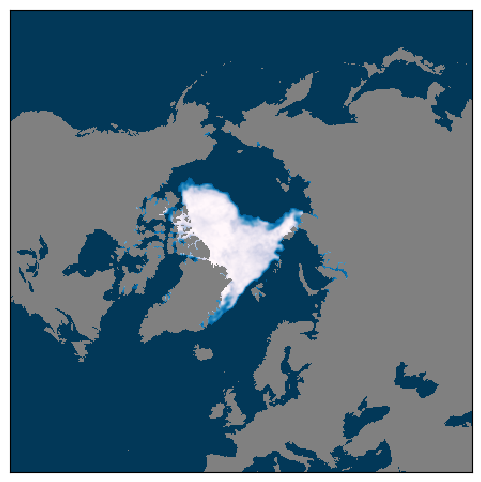

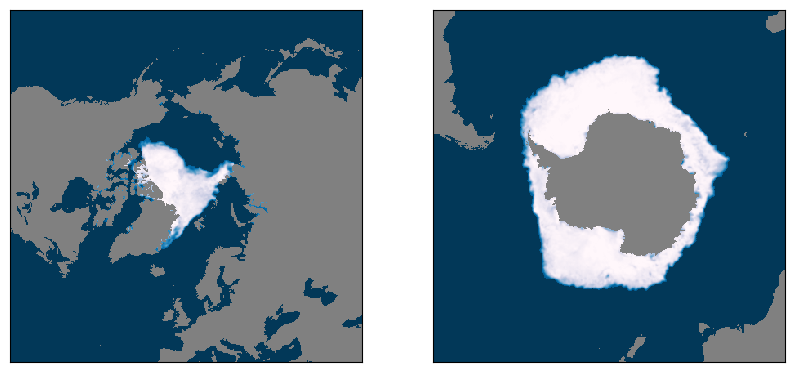

In [5]:
def simple_plot(ds, ax=None):
    cmap = cm.magma.with_extremes(bad='grey')
    cmap = cm.PuBu_r.with_extremes(bad='grey')
    
    if ax is None:
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(1,1,1)
    
    ax.imshow(ds['ice_conc'][0], interpolation='none', cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])
    
    return ax

# plot 1 panel
simple_plot(ds)
plt.show()

# plot two panels side-by-side
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,2,1)
simple_plot(ds, ax=ax)
ax = fig.add_subplot(1,2,2)
simple_plot(xr.open_dataset(get_sic_url(dt,'sh', cdr='osisaf-v3-cdr')), ax=ax)
plt.show()

## Plot a contour of the sea-ice cover

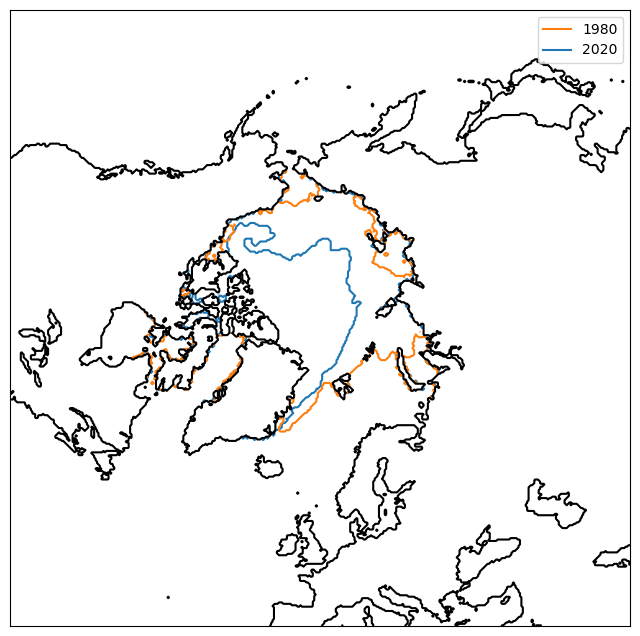

In [6]:
import matplotlib.lines as mlines


# access the two dates
ds_1980 = xr.open_dataset(get_sic_url(date(1980,9,15),'nh', cdr='osisaf-v3-cdr'))
ds_2020 = xr.open_dataset(get_sic_url(date(2020,9,15),'nh', cdr='osisaf-v3-cdr'))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)

# plot the sea ice contour (at 50% SIC level), and the lines for the legend
ax.contour(ds_2020['ice_conc'][0], levels=(0.5,), colors='C0', origin='upper',)
ln_2020 = mlines.Line2D([], [], color='C0', label='2020')

ax.contour(ds_1980['ice_conc'][0], levels=(0.5,), colors='C1', origin='upper')
ln_1980 = mlines.Line2D([], [], color='C1', label='1980')

# add contour of the landmask
landmask=ds_2020['ice_conc'][0].to_masked_array().mask
ax.contour(landmask.astype('float'), levels=(0.5,), colors='k', origin='upper')

# add the legend
ax.legend(handles=[ln_1980, ln_2020])

# remove x/y-ticks
ax.set_xticks([])
ax.set_yticks([])

plt.show()

## Compare several CDRs for the same date

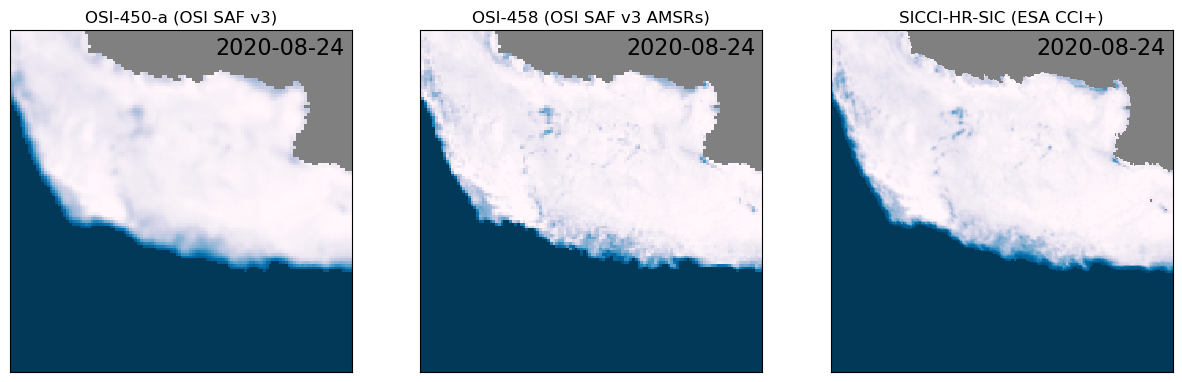

In [7]:
area = 'sh'
dt = date(2020,8,24)
ds_osi450a  = xr.open_dataset(get_sic_url(dt, area, cdr='osisaf-v3-cdr'))
ds_osi458   = xr.open_dataset(get_sic_url(dt, area, cdr='osisaf-v3-amsr'))
ds_siccipHR = xr.open_dataset(get_sic_url(dt, area, cdr='sicci-hr-sic'))


if area == 'nh':
    xlim = (175,275)
    ylim = (300,200)
elif area == 'sh':
    xlim = (125,250)
    ylim = (375,250)

# plot three panels side-by-side
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,3,1)
simple_plot(ds_osi450a, ax=ax)
ax.set_title("OSI-450-a (OSI SAF v3)")
ax.text(0.98,0.98,dt,va='top',ha='right',transform=ax.transAxes, fontsize=16)
ax = fig.add_subplot(1,3,2, sharex=ax, sharey=ax)
simple_plot(ds_osi458, ax=ax)
ax.set_title("OSI-458 (OSI SAF v3 AMSRs)")
ax.text(0.98,0.98,dt,va='top',ha='right',transform=ax.transAxes, fontsize=16)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

ax = fig.add_subplot(1,3,3,)
simple_plot(ds_siccipHR, ax=ax)
ax.set_xlim(2*xlim[0],2*xlim[1])
ax.set_ylim(2*ylim[0],2*ylim[1])
ax.set_title("SICCI-HR-SIC (ESA CCI+)")
ax.text(0.98,0.98,dt,va='top',ha='right',transform=ax.transAxes, fontsize=16)


plt.savefig('Comparison_SIC.png', bbox_inches='tight', dpi=150)
plt.show()

## Read and plot OSI SAF v3 SIC for recent dates

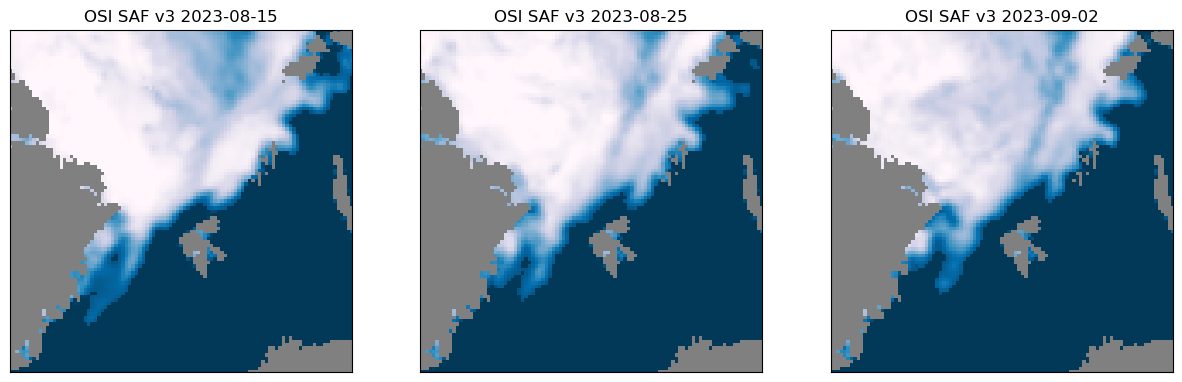

In [8]:
area = 'nh'
dt0 = datetime.today().date() - timedelta(days=2)
dt1 = datetime.today().date() - timedelta(days=10)
dt2 = datetime.today().date() - timedelta(days=20)

fn_dt0 = find_sic_file(dt0, area, src_prioritized_list=('osisaf-v3',))[0]
ds_dt0  = xr.open_dataset(fn_dt0)
ds_dt1  = xr.open_dataset(find_sic_file(dt1, area, src_prioritized_list=('osisaf-v3',))[0])
ds_dt2  = xr.open_dataset(find_sic_file(dt2, area, src_prioritized_list=('osisaf-v3',))[0])


if area == 'nh':
    xlim = (175,275)
    ylim = (300,200)
elif area == 'sh':
    xlim = (125,250)
    ylim = (375,250)

# plot three panels side-by-side
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,3,1)
simple_plot(ds_dt2, ax=ax)
ax.set_title("OSI SAF v3 {}".format(dt2))

ax = fig.add_subplot(1,3,2, sharex=ax, sharey=ax)
simple_plot(ds_dt1, ax=ax)
ax.set_title("OSI SAF v3 {}".format(dt1))
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

ax = fig.add_subplot(1,3,3, sharex=ax, sharey=ax)
simple_plot(ds_dt0, ax=ax)
ax.set_title("OSI SAF v3 {}".format(dt0))
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
                          
plt.show()               